# XGBoost Model Using Historical Sales Data Only
## Table of Contents

1. [Import Libraries](#Import_Libraries)
2. [Setup MLFlow Tracking](#MLFlow_Tracking)
3. [Load Data](#Load_Data)
4. [Pre-Process Data](#Pre_Processing)


5. Product Categories
   
   5.1 [Bed, Bath and Table](#bed_bath_table) 
   
   5.2 [Health and Beauty](#health_beauty)
   
   5.3 [Sports and Leisure](#sports_leisure)
   
   5.4 [Furniture Decor](#furniture_decor)
   
   5.5 [Watches and Gifts](#watches_gifts)
   
   5.6 [Telephony](#telephony)
   
   5.7 [Housewares](#housewares)


# Import Libraries <a name = "Import_Libraries"/>

In [1]:
import sys
import os
from utils import utils, metrics, dataset_2
import json
from pprint import pprint
import re
import pandas as pd                        # pandas, the magical dataframe library
import matplotlib.pyplot as plt             # matplotlib.pylot plots data 
plt.style.use('bmh')
import numpy as np                         # numpy provides N-dimensional object support 
import datetime as dt
import seaborn as sns
import math
import matplotlib.mlab as mlab
from sklearn import preprocessing
#conduct data plotting inline instead of in a separate windor
%matplotlib inline 
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, median_absolute_error
from math import sqrt
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, plotting, space_eval
import mlflow

C:\Users\feras\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\feras\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\Users\feras\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


# Setup MLFlow Tracking <a name = "MLFlow_Tracking"/>

https://www.mlflow.org/docs/latest/tracking.html

In [2]:
# If this is the first time running the notebook, uncomment next line.
#This is to create a file called mlruns which will store the logs for each time the notebook is run

#mlflow_experiment_id = mlflow.create_experiment('Olist_XGBoost_Historical_MLFlow')

#else:
mlflow.set_experiment('Olist_XGBoost_Historical_MLFlow')
client = mlflow.tracking.MlflowClient()
# See ui 
#!mlflow ui

# Load Data <a name = "Load_Data"/>

In [3]:
# Read Config file
config = "configs_XGBoost.json"

try:
    with open(config, "r") as f:
        config = json.load(f)
        print('\033[92m','Load successfull. config = \n')
        pprint(config)
except:
    raise IOError(f"Impossible to read config file: {config}")

 Load successfull. config = 

{'dates': {'test_end': '2017-12-14',
           'test_start': '2017-12-1',
           'train_start': '2017-07-01',
           'valid_start': '2017-11-21'},
 'directories': {'base_dir': 'brazilian-ecommerce'},
 'drop_date': False,
 'end_date': '2017-12-31 23:59:59',
 'pre_processing': {'add_date_features': True,
                    'col_name': 'payment_value',
                    'impute_nan': 'zero',
                    'r_list': [7, 15],
                    'rolling_history': True,
                    'window_size': 7},
 'product_categories': ['bed_bath_table',
                        'health_beauty',
                        'sports_leisure',
                        'furniture_decor',
                        'computer_accessories',
                        'housewares',
                        'watches_gifts',
                        'telephony',
                        'garden_tools',
                        'auto'],
 'rm_product_category': False,
 'start

# Pre-Process Training, Validate and Test Datasets <a name = "Pre_Processing"/>

In [5]:
df_train, df_valid, df_test, = dataset_2.make_dataset(config)

_=df_train.pop('order_approved_at').unique()

# Store dates for use in plotting results
valid_dates = df_valid.pop('order_approved_at').unique()
test_dates = df_test.pop('order_approved_at').unique()

array(['2017-11-21T00:00:00.000000000', '2017-11-22T00:00:00.000000000',
       '2017-11-23T00:00:00.000000000', '2017-11-24T00:00:00.000000000',
       '2017-11-25T00:00:00.000000000', '2017-11-26T00:00:00.000000000',
       '2017-11-27T00:00:00.000000000', '2017-11-28T00:00:00.000000000',
       '2017-11-29T00:00:00.000000000', '2017-11-30T00:00:00.000000000'],
      dtype='datetime64[ns]')

# Product Category 1: Bed, Bath and Table <a name = "bed_bath_table"/>

In [7]:
#Filter on product categories (series)
bed_bath_table_train = df_train.loc[df_train['product_category_name'] == 'bed_bath_table'].copy()
bed_bath_table_valid = df_valid.loc[df_valid['product_category_name'] == 'bed_bath_table'].copy()
bed_bath_table_test = df_test.loc[df_test['product_category_name'] == 'bed_bath_table'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

bed_bath_table_train.drop(columns, inplace=True, axis=1)
bed_bath_table_valid.drop(columns, inplace=True, axis=1)
bed_bath_table_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = bed_bath_table_train.loc[:, bed_bath_table_train.columns != 'payment_value']
y_train = bed_bath_table_train.loc[:, bed_bath_table_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = bed_bath_table_valid.loc[:, bed_bath_table_valid.columns != 'payment_value']
y_val = bed_bath_table_valid.loc[:, bed_bath_table_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = bed_bath_table_test.loc[:, bed_bath_table_test.columns != 'payment_value']
y_test = bed_bath_table_test.loc[:, bed_bath_table_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)


### Hyperparameter Optimization Using Hyperopt

In [8]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [9]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

#with mlflow.start_run():
    #mlflow.log_param('model parameters', 'params')

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:33<00:00,  5.91trial/s, best loss: 0.4009832935274579]
The best hyperparameters are: {'colsample_bytree': 0.9, 'eta': 0.128, 'max_depth': 5, 'min_child_weight': 2.0, 'n_estimators': 70, 'subsample': 0.7000000000000001}


In [10]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

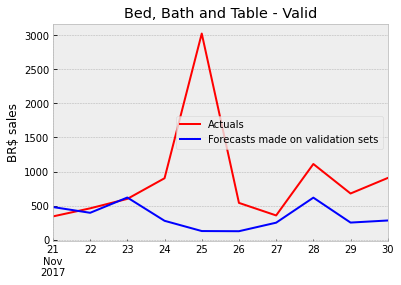

In [11]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals')
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Bed, Bath and Table - Valid')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [12]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Product Category','Bed, Bath and Table')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 622e09dd370f4ed8b5dd0b40e790e262


In [13]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 945622.4829536838
rms: 992.4032322639704
r2: -0.7426530319849312
mape: 0.5454499690950043


### Train & Run the XGBoost Model

Use optimized parameters determined by Hyperopt on the validation set

In [14]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = bed_bath_table_train.loc[:, bed_bath_table_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

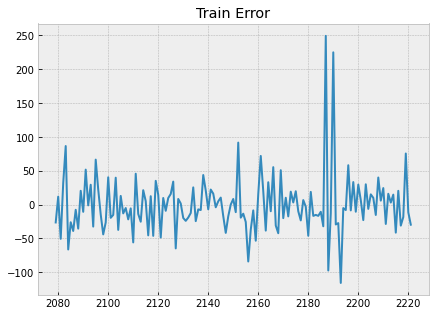

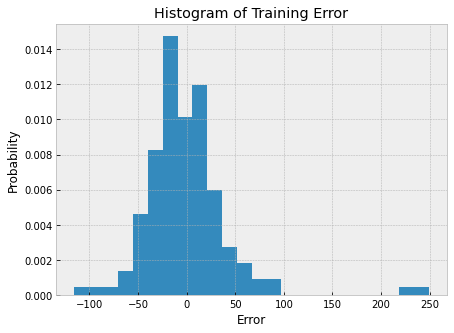

In [15]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(bed_bath_table_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(bed_bath_table_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [16]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [17]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 97485.14752363731
rms: 302.9321209905333
r2: -0.16347075296662994
mape: 0.7586880270948854


### Plot Actuals & Forecasts

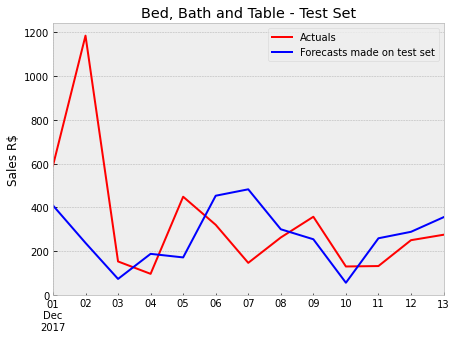

In [18]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Bed, Bath and Table - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

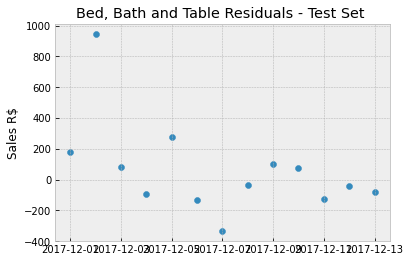

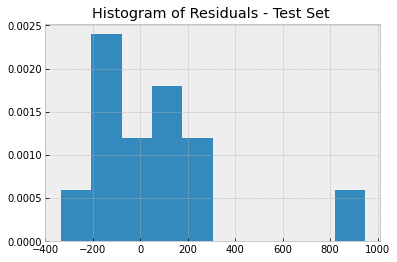

In [19]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Bed, Bath and Table Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

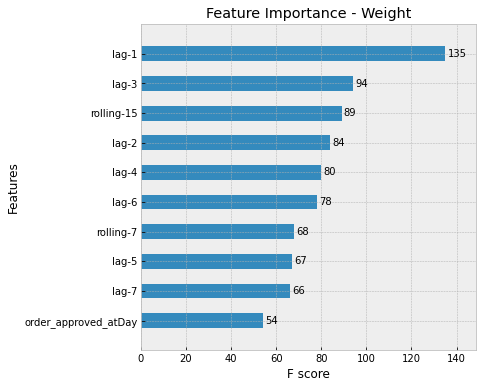

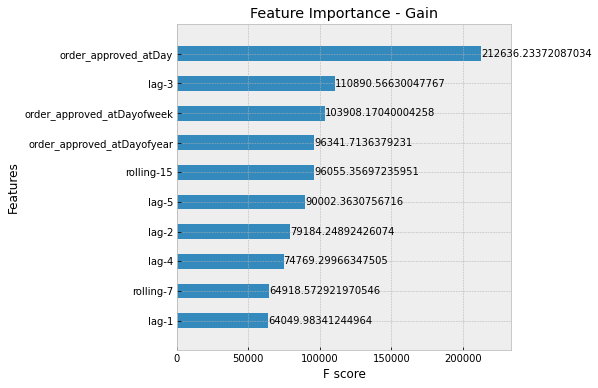

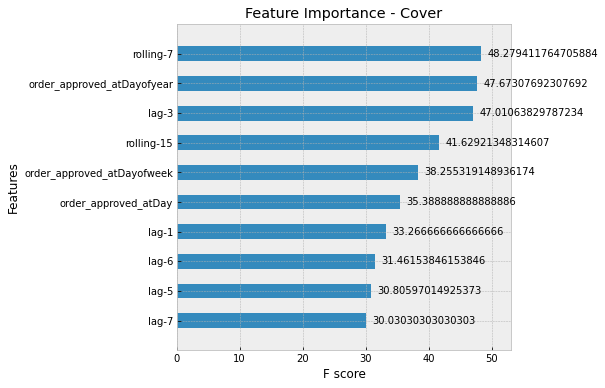

In [20]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

### Plot Regression Trees

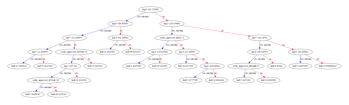

In [19]:
xgb.plot_tree(xg_boost_model,num_trees=0)
plt.rcParams['figure.figsize'] = [64, 64]
plt.show()

# Product Category 2: Heath & Beauty <a name = "health_beauty"/>

In [20]:
#Filter on product categories (series)
health_beauty_train = df_train.loc[df_train['product_category_name'] == 'health_beauty'].copy()
health_beauty_valid = df_valid.loc[df_valid['product_category_name'] == 'health_beauty'].copy()
health_beauty_test = df_test.loc[df_test['product_category_name'] == 'health_beauty'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

health_beauty_train.drop(columns, inplace=True, axis=1)
health_beauty_valid.drop(columns, inplace=True, axis=1)
health_beauty_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = health_beauty_train.loc[:, health_beauty_train.columns != 'payment_value']
y_train = health_beauty_train.loc[:, health_beauty_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = health_beauty_valid.loc[:, health_beauty_valid.columns != 'payment_value']
y_val = health_beauty_valid.loc[:, health_beauty_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = health_beauty_test.loc[:, health_beauty_test.columns != 'payment_value']
y_test = health_beauty_test.loc[:, health_beauty_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)


### Hyperparameter Optimization Using Hyperopt

In [21]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [22]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:31<00:00,  6.42trial/s, best loss: 0.6417144338521004]
The best hyperparameters are: {'colsample_bytree': 0.55, 'eta': 0.028, 'max_depth': 2, 'min_child_weight': 1.0, 'n_estimators': 57, 'subsample': 0.6000000000000001}


In [23]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

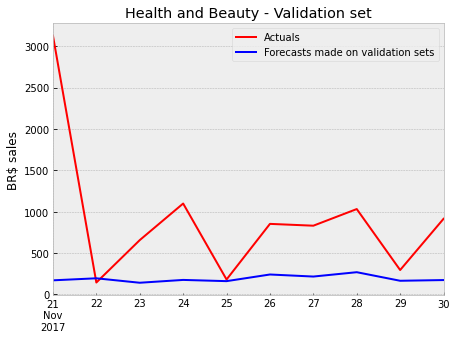

In [24]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Health and Beauty - Validation set')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [25]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Product Category','Health and Beauty')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: af8cc7de34374ef8876ca9cc9fb13cbb


In [26]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 1042554.4854654664
rms: 1085.3779696990769
r2: -0.7992046019458292
mape: 0.6481264407729583


### Train & Run the XGBoost Model
Use optimized parameters determined by Hyperopt on the validation set

In [27]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = health_beauty_train.loc[:, health_beauty_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

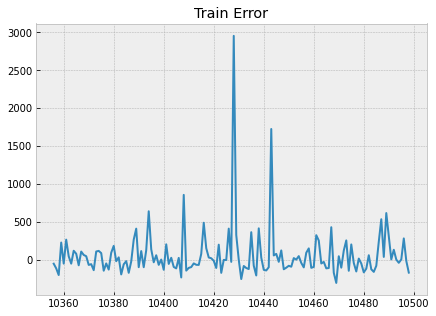

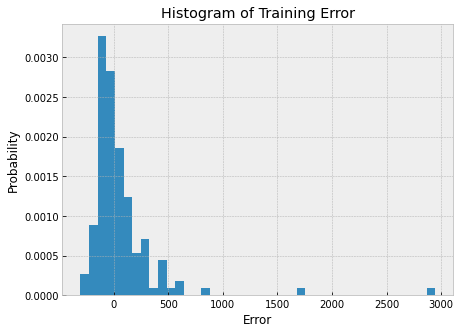

In [28]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(health_beauty_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(health_beauty_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [29]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [30]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 123772.53005502411
rms: 358.14822119323077
r2: -0.21496932925913126
mape: 24.81685158601559


### Plot Actuals & Forecasts

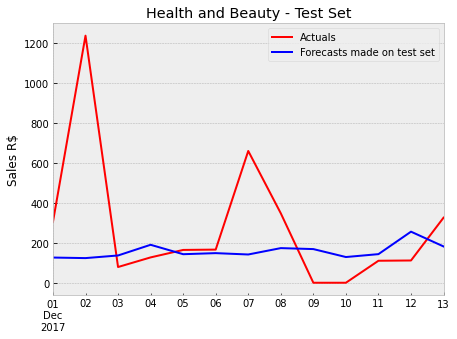

In [31]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Health and Beauty - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

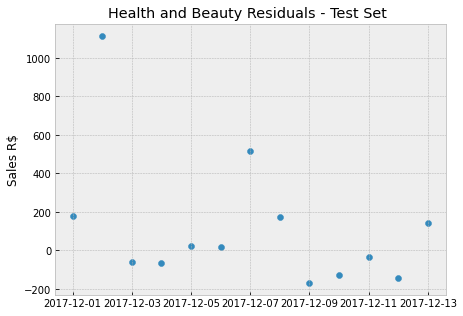

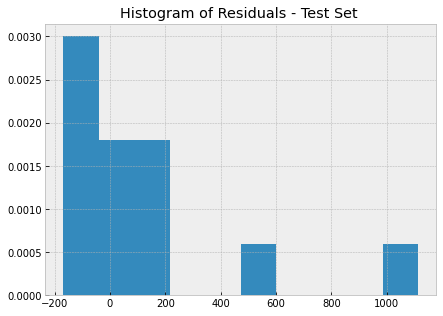

In [32]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Health and Beauty Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover¶

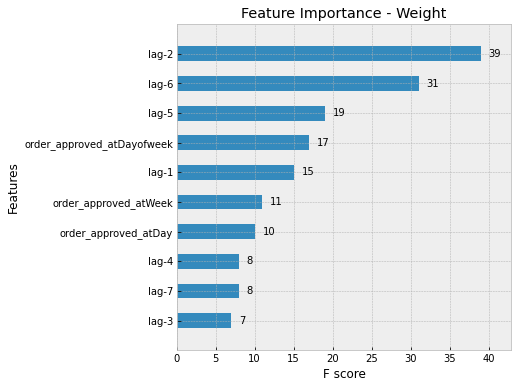

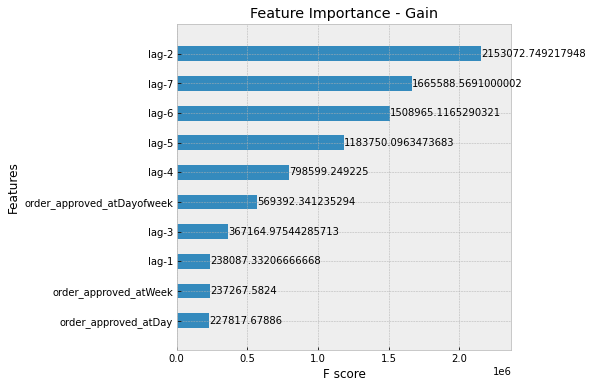

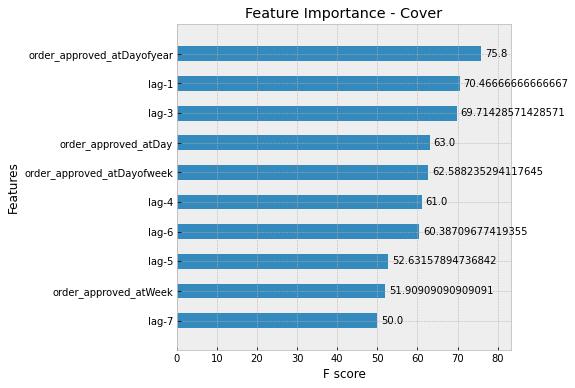

In [33]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

### Plot Regression Trees

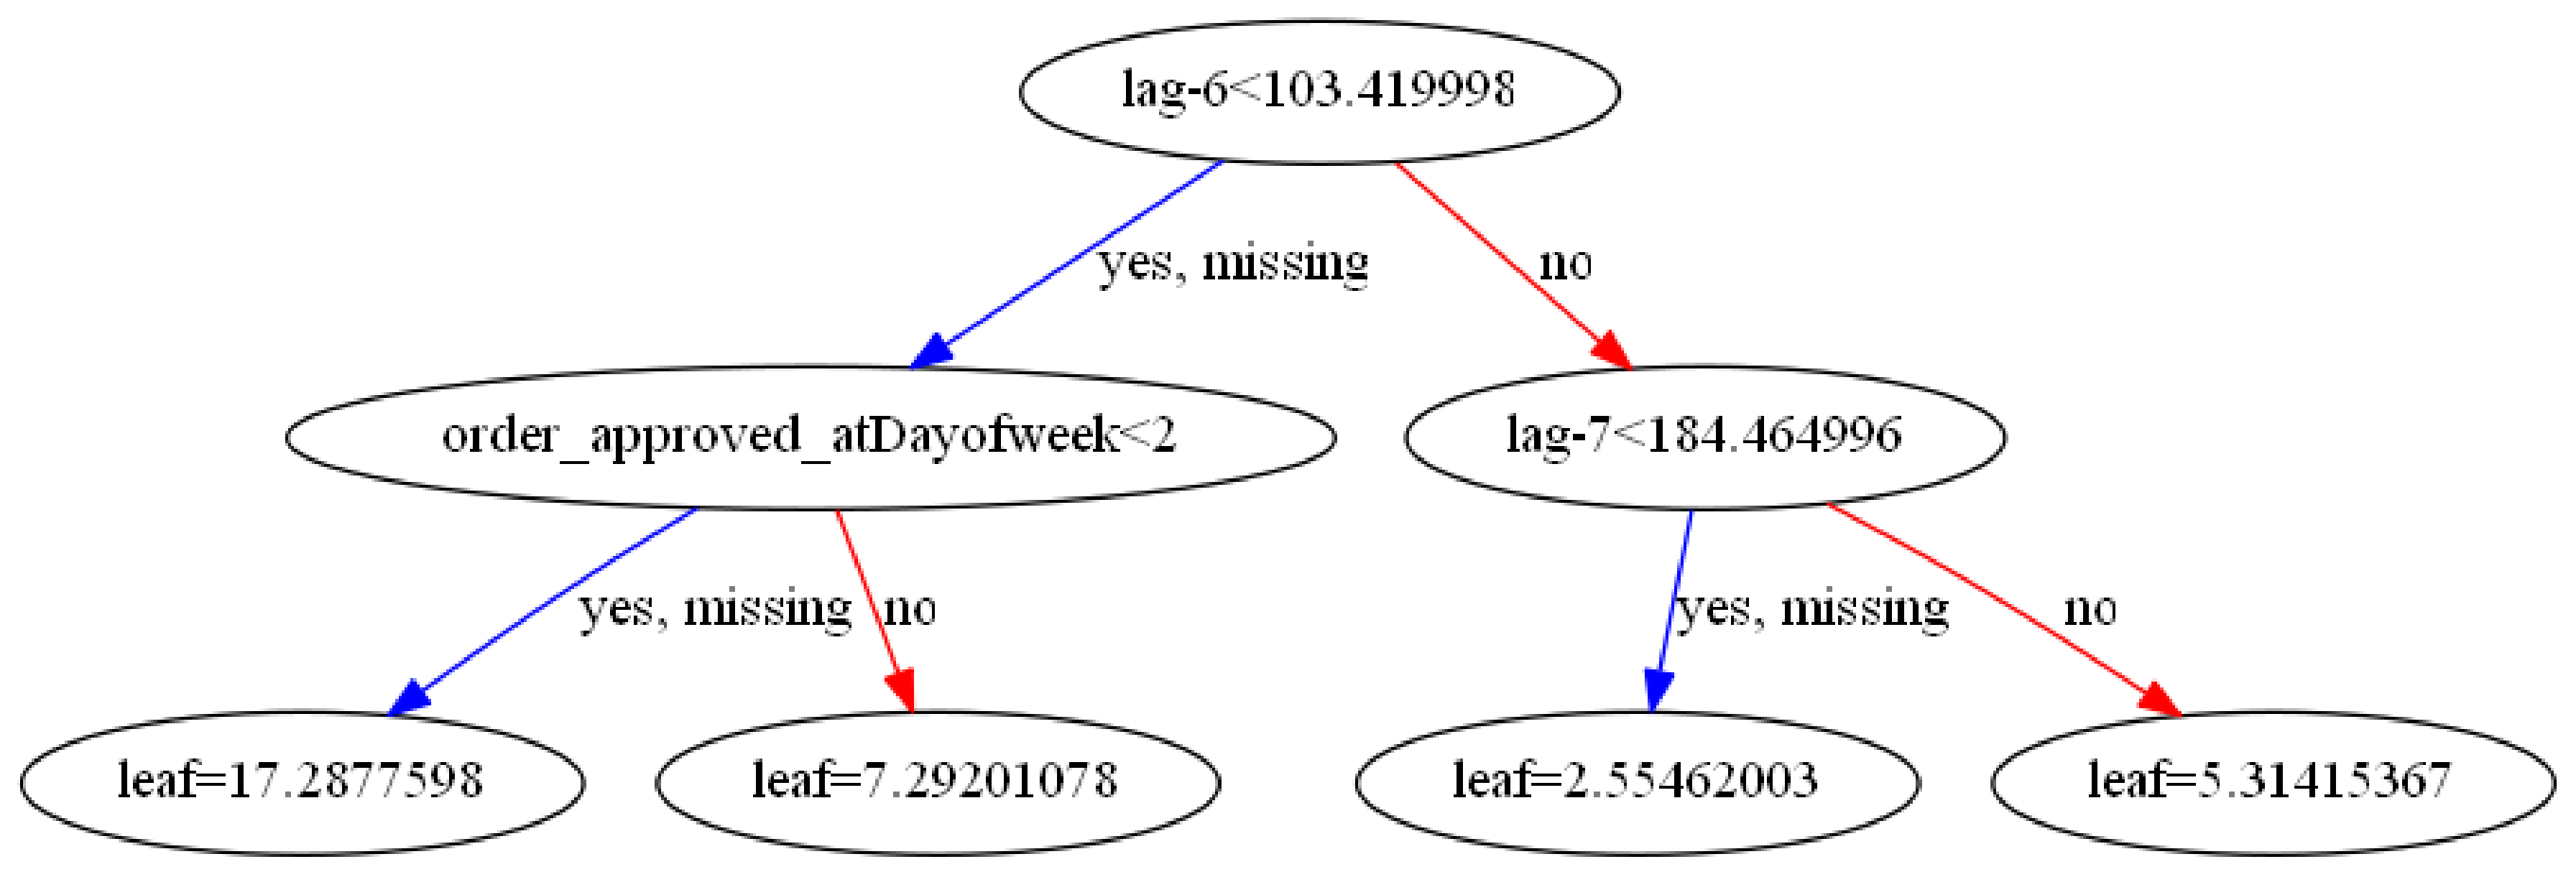

In [34]:
xgb.plot_tree(xg_boost_model,num_trees=0)
plt.rcParams['figure.figsize'] = [64, 64]
plt.show()

# Product Category 3: Sports and Leisure <a name = "sports_leisure"/>

In [35]:
#Filter on product categories (series)
sports_leisure_train = df_train.loc[df_train['product_category_name'] == 'sports_leisure'].copy()
sports_leisure_valid = df_valid.loc[df_valid['product_category_name'] == 'sports_leisure'].copy()
sports_leisure_test = df_test.loc[df_test['product_category_name'] == 'sports_leisure'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

sports_leisure_train.drop(columns, inplace=True, axis=1)
sports_leisure_valid.drop(columns, inplace=True, axis=1)
sports_leisure_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = sports_leisure_train.loc[:, sports_leisure_train.columns != 'payment_value']
y_train = sports_leisure_train.loc[:, sports_leisure_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = sports_leisure_valid.loc[:, sports_leisure_valid.columns != 'payment_value']
y_val = sports_leisure_valid.loc[:, sports_leisure_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = sports_leisure_test.loc[:, sports_leisure_test.columns != 'payment_value']
y_test = sports_leisure_test.loc[:, sports_leisure_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)


### Hyperparameter Optimization Using Hyperopt

In [36]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [37]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:31<00:00,  6.43trial/s, best loss: 0.4021320790244251]
The best hyperparameters are: {'colsample_bytree': 0.55, 'eta': 0.17, 'max_depth': 3, 'min_child_weight': 1.0, 'n_estimators': 28, 'subsample': 0.6000000000000001}


In [38]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

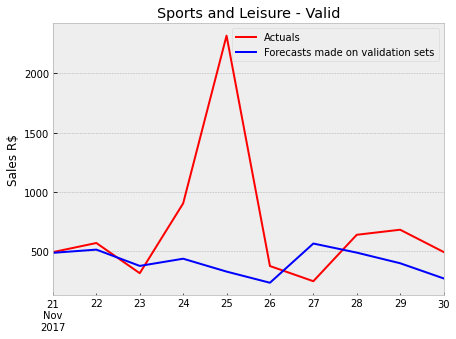

In [39]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals',figsize=(7,5))
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Sports and Leisure - Valid')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

In [40]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Product Category','Sports and Leisure')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: b0bfa670ff214aaaabb6a1aa01899ac2


In [41]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 492209.97275754623
rms: 668.6659281256462
r2: -0.38196543289214646
mape: 0.4131417942245294


### Train & Run the XGBoost Model
Use optimized parameters determined by Hyperopt on the validation set

In [42]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = sports_leisure_train.loc[:, sports_leisure_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

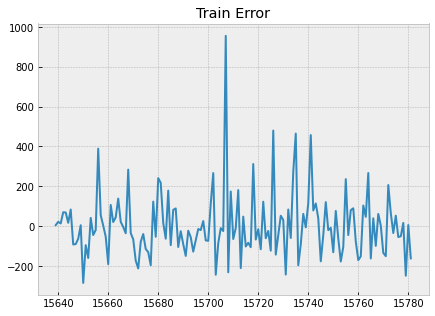

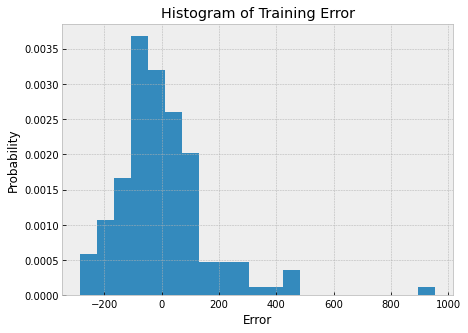

In [43]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(sports_leisure_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(sports_leisure_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [44]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [45]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 933138.0120223333
rms: 948.790560986105
r2: -0.3175296587209113
mape: 0.7209838044390218


### Plot Actuals & Forecasts

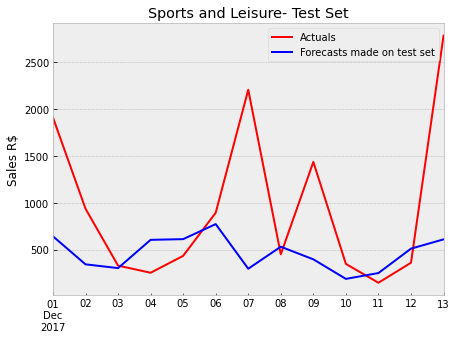

In [46]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Sports and Leisure- Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

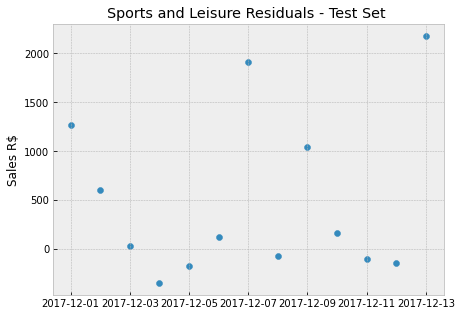

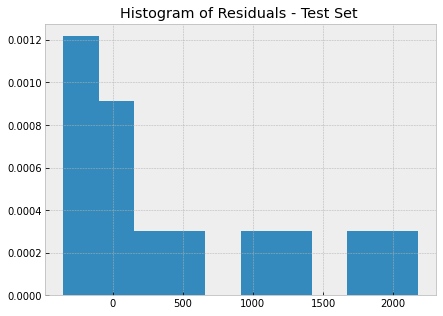

In [47]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Sports and Leisure Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

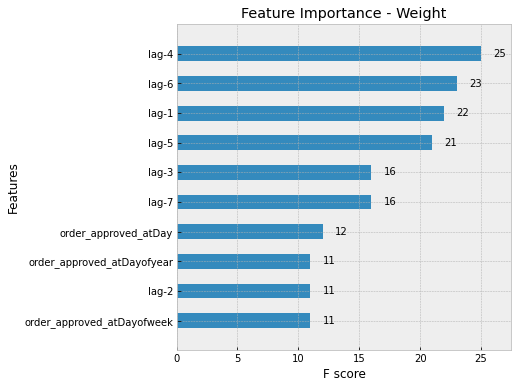

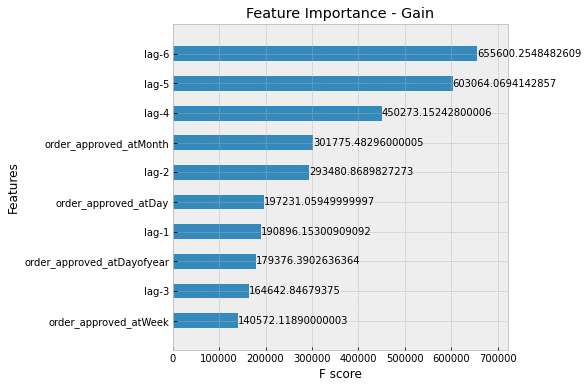

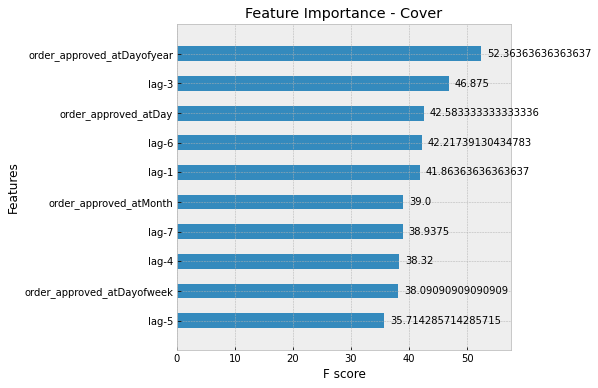

In [48]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

### Plot Regression Trees

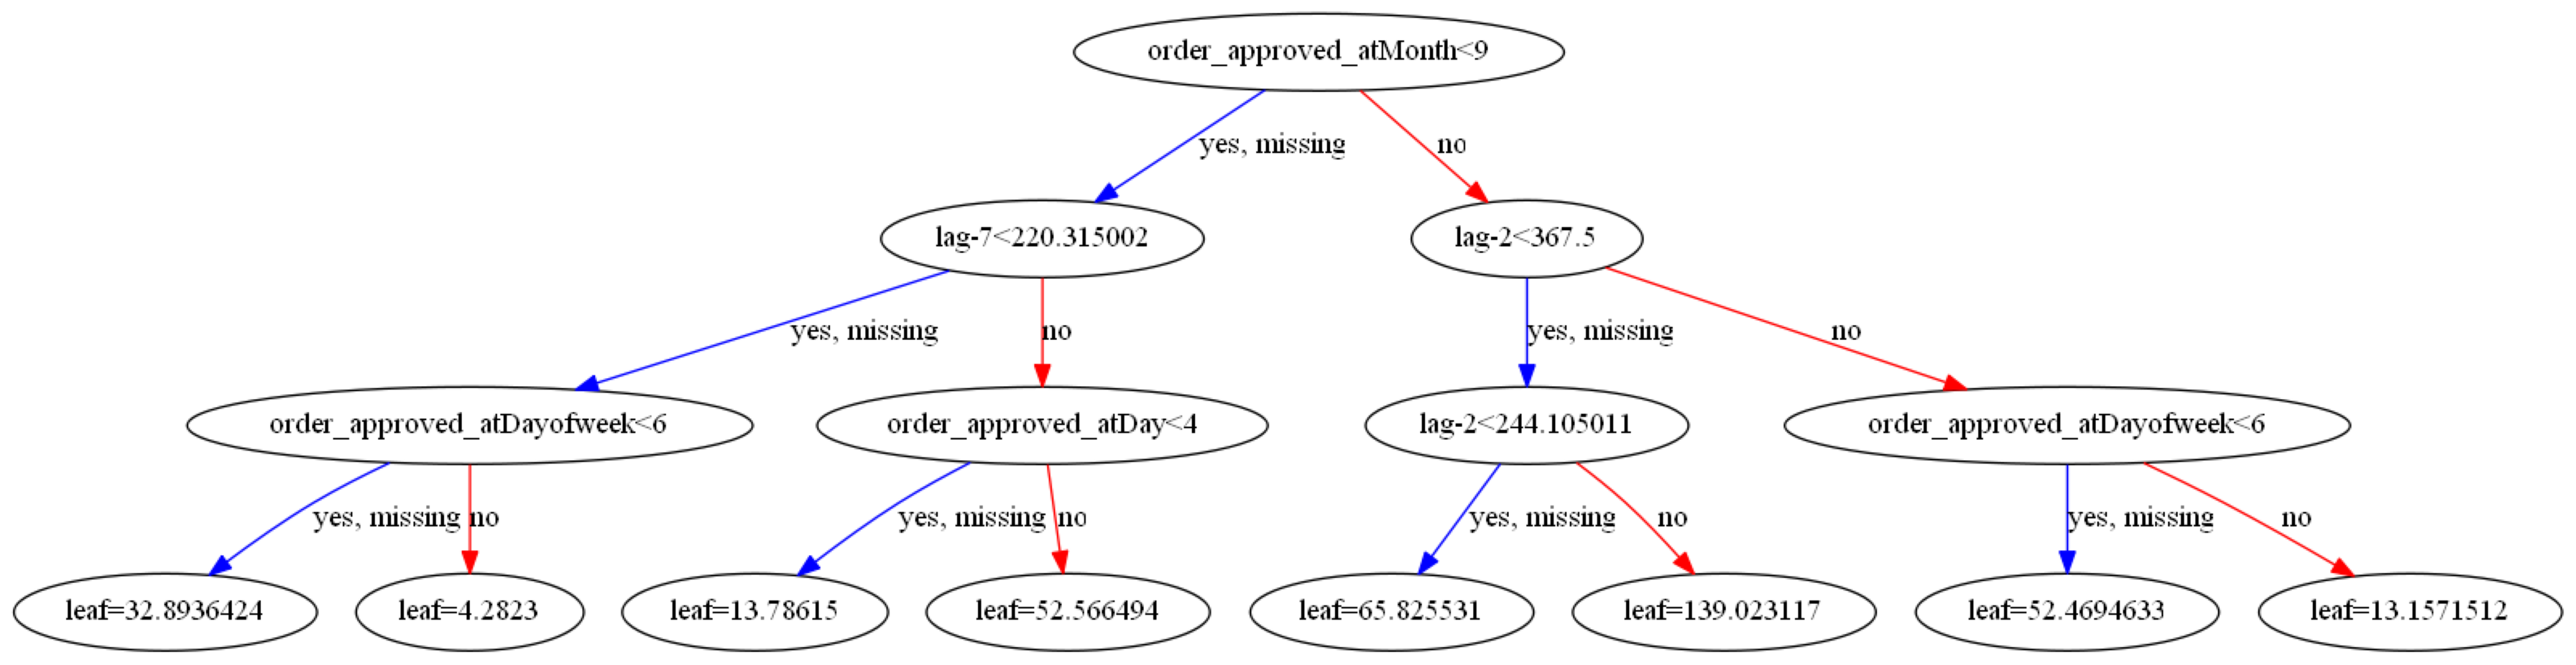

In [49]:
xgb.plot_tree(xg_boost_model,num_trees=0)
plt.rcParams['figure.figsize'] = [64, 64]
plt.show()

# Product Category 4: Furniture Decor <a name = "furniture_decor"/>

In [50]:
#Filter on product categories (series)
furniture_decor_train = df_train.loc[df_train['product_category_name'] == 'furniture_decor'].copy()
furniture_decor_valid = df_valid.loc[df_valid['product_category_name'] == 'furniture_decor'].copy()
furniture_decor_test = df_test.loc[df_test['product_category_name'] == 'furniture_decor'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

furniture_decor_train.drop(columns, inplace=True, axis=1)
furniture_decor_valid.drop(columns, inplace=True, axis=1)
furniture_decor_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = furniture_decor_train.loc[:, furniture_decor_train.columns != 'payment_value']
y_train = furniture_decor_train.loc[:, furniture_decor_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = furniture_decor_valid.loc[:, furniture_decor_valid.columns != 'payment_value']
y_val = furniture_decor_valid.loc[:, furniture_decor_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = furniture_decor_test.loc[:, furniture_decor_test.columns != 'payment_value']
y_test = furniture_decor_test.loc[:, furniture_decor_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)


### Hyperparameter Optimization Using Hyperopt

In [51]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [52]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:41<00:00,  4.77trial/s, best loss: 0.7249418061147379]
The best hyperparameters are: {'colsample_bytree': 0.75, 'eta': 0.036000000000000004, 'max_depth': 2, 'min_child_weight': 1.0, 'n_estimators': 16, 'subsample': 0.65}


In [53]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

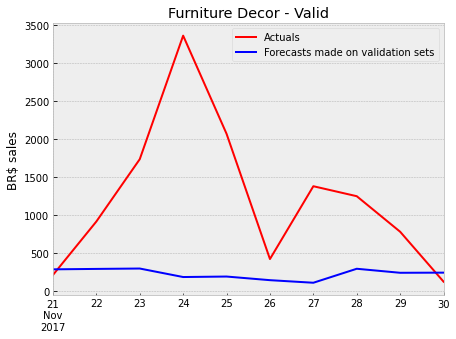

In [54]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals',figsize=(7,5))
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Furniture Decor - Valid')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [55]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Product Category','Furniture Decor')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: aa9487d1a74c4d78a3d423d466f049ff


In [56]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 1580499.053739296
rms: 1379.300972310942
r2: -1.1729269875764845
mape: 0.7433224254466616


### Train & Run the XGBoost Model
Use optimized parameters determined by Hyperopt on the validation set

In [57]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = furniture_decor_train.loc[:, furniture_decor_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

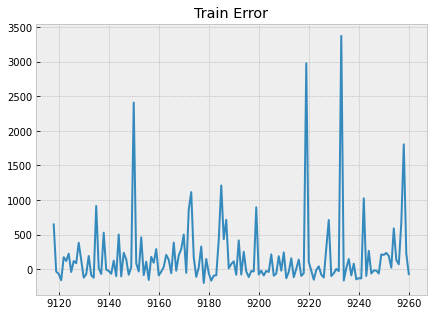

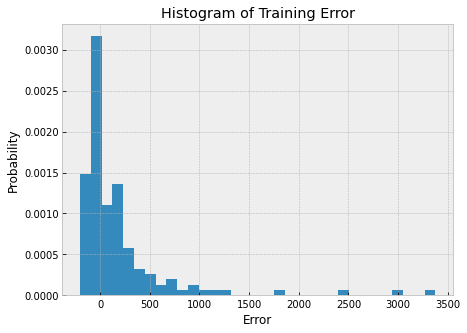

In [58]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(furniture_decor_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(furniture_decor_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [59]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [60]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 264728.404915003
rms: 520.5844362411617
r2: -0.08941417982691702
mape: 35.25341691525113


### Plot Actuals & Forecasts

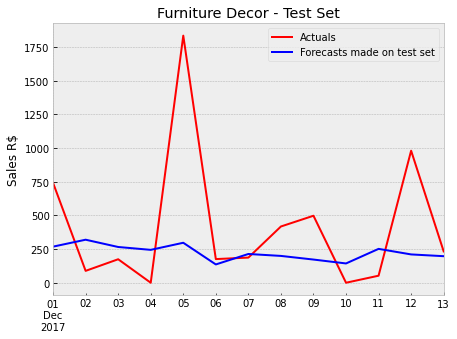

In [61]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Furniture Decor - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

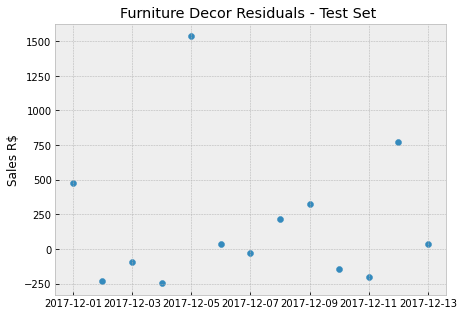

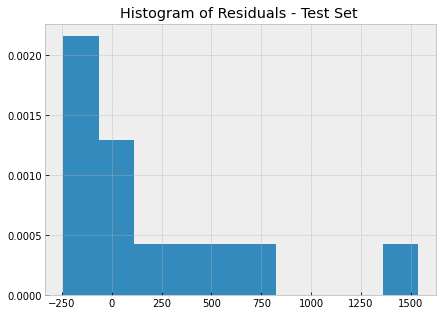

In [62]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Furniture Decor Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

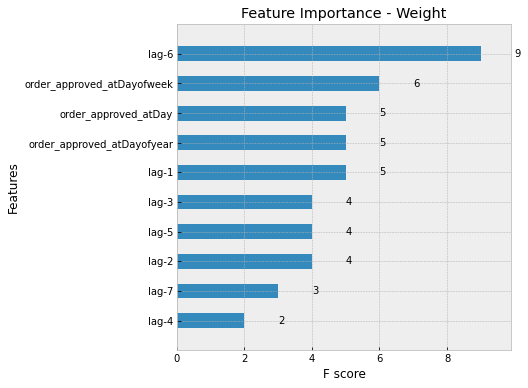

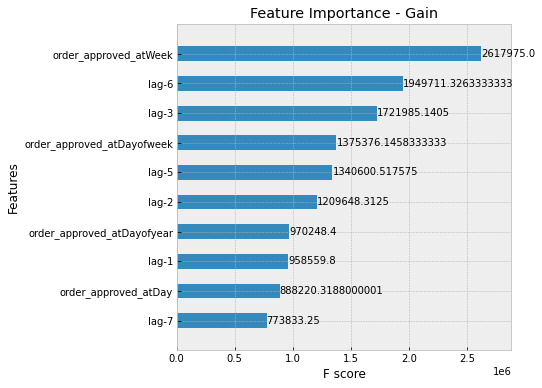

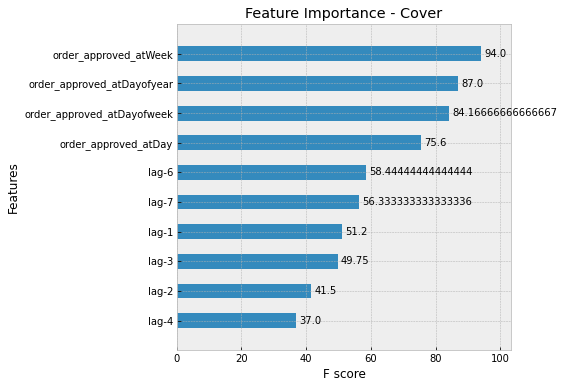

In [63]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

### Plot Regression Trees

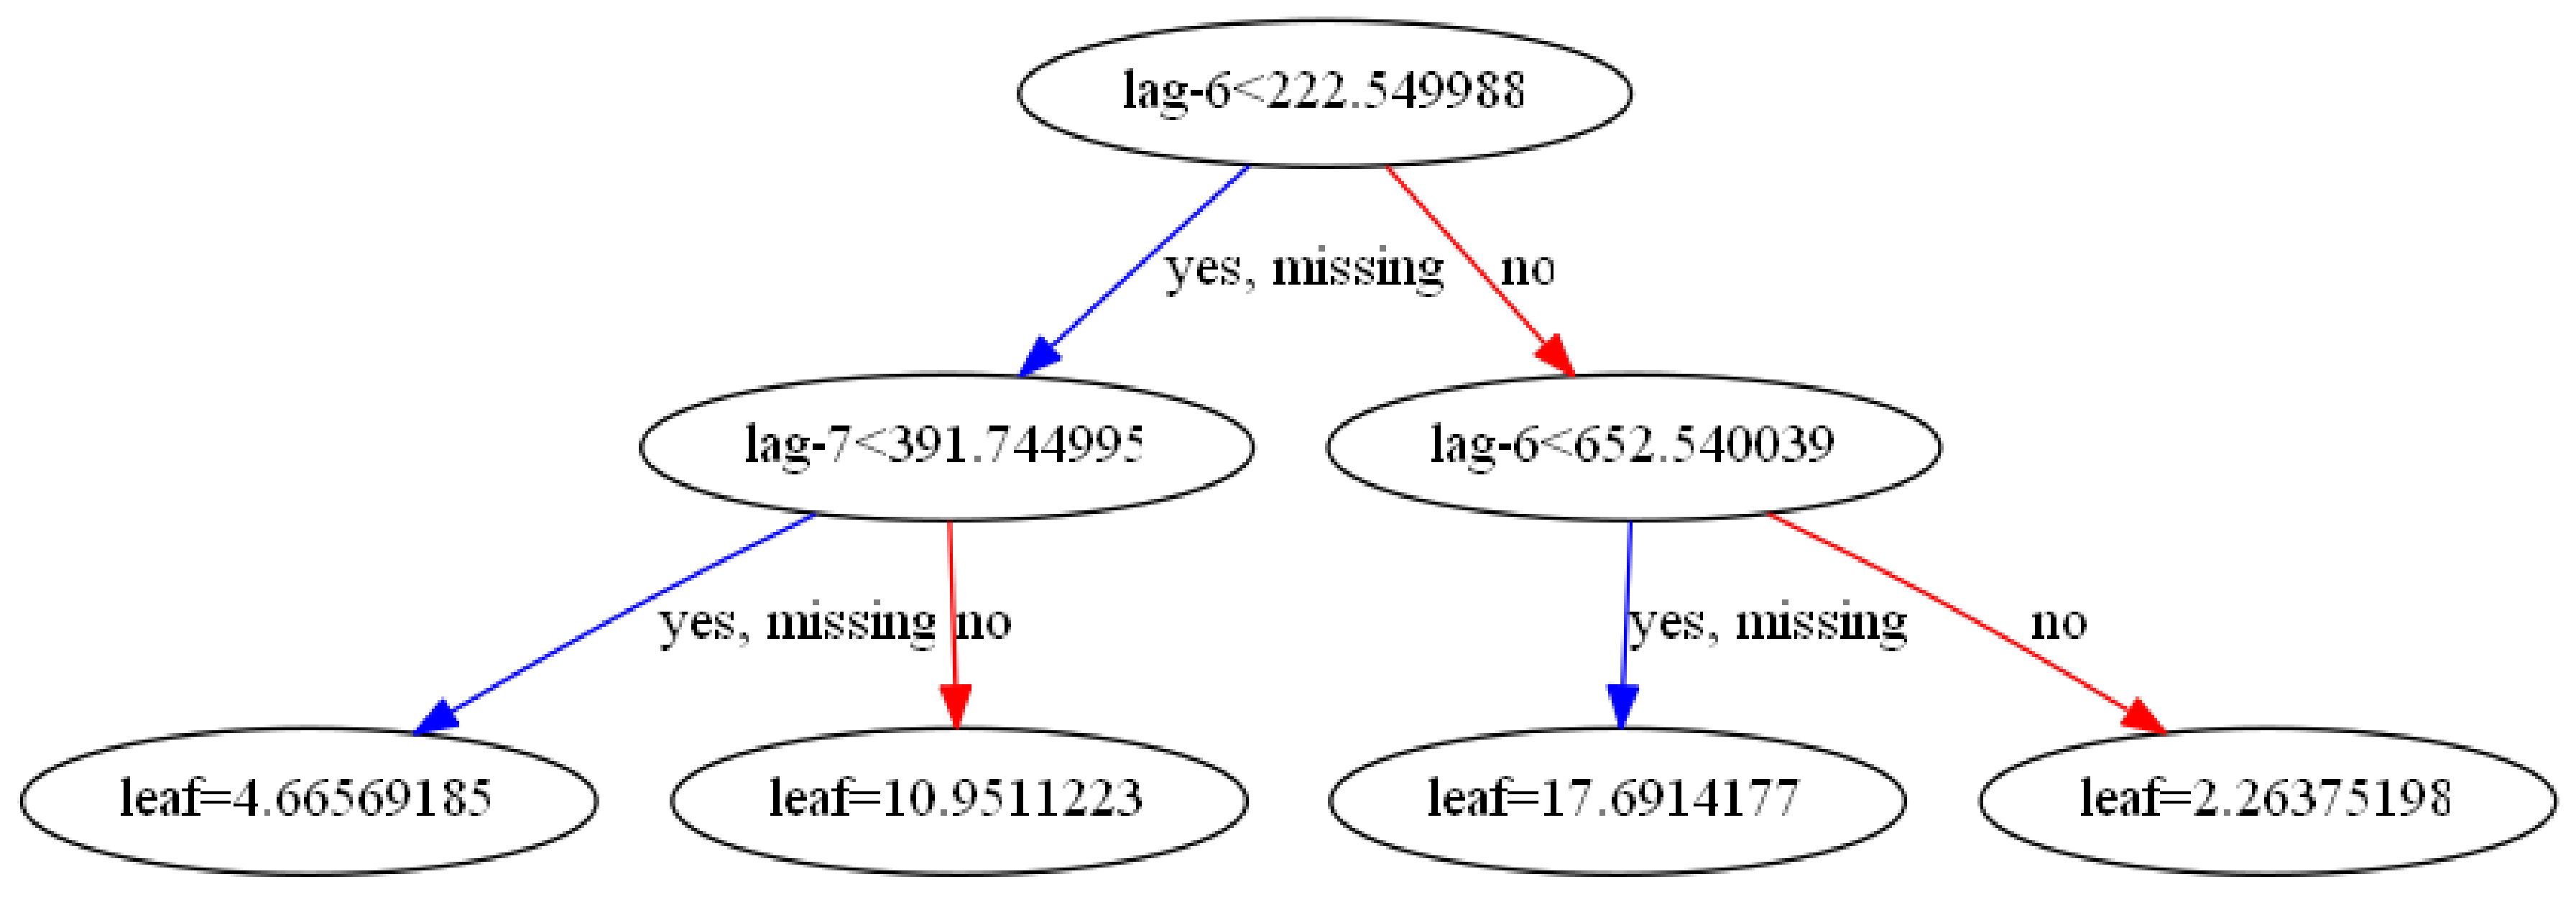

In [64]:
xgb.plot_tree(xg_boost_model,num_trees=0)
plt.rcParams['figure.figsize'] = [64, 64]
plt.show()

# Product Category 5: Watches Gifts <a name = "watches_gifts"/>

In [65]:
#Filter on product categories (series)
watches_gifts_train = df_train.loc[df_train['product_category_name'] == 'watches_gifts'].copy()
watches_gifts_valid = df_valid.loc[df_valid['product_category_name'] == 'watches_gifts'].copy()
watches_gifts_test = df_test.loc[df_test['product_category_name'] == 'watches_gifts'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

watches_gifts_train.drop(columns, inplace=True, axis=1)
watches_gifts_valid.drop(columns, inplace=True, axis=1)
watches_gifts_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = watches_gifts_train.loc[:, watches_gifts_train.columns != 'payment_value']
y_train = watches_gifts_train.loc[:, watches_gifts_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = watches_gifts_valid.loc[:, watches_gifts_valid.columns != 'payment_value']
y_val = watches_gifts_valid.loc[:, watches_gifts_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = watches_gifts_test.loc[:, watches_gifts_test.columns != 'payment_value']
y_test = watches_gifts_test.loc[:, watches_gifts_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)


### Hyperparameter Optimization Using Hyperopt

In [66]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [67]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:43<00:00,  4.62trial/s, best loss: 2.1391795513868592]
The best hyperparameters are: {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 9, 'min_child_weight': 1.0, 'n_estimators': 9, 'subsample': 1.0}


In [68]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

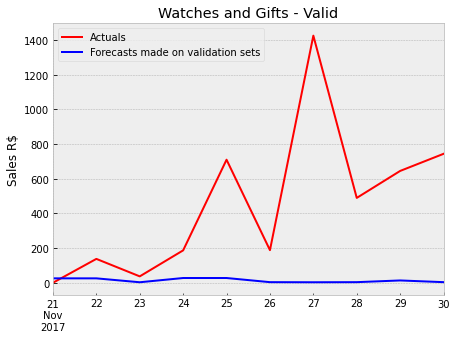

In [69]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals',figsize=(7,5))
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Watches and Gifts - Valid')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

In [70]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Product Category','Watches and Gifts')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 2b695f8cfd544da1be91a05591bc58eb


In [71]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 283630.30069548724
rms: 612.194769166404
r2: -1.137380254056922
mape: 2.168594001572136


### Train & Run the XGBoost Model
Use optimized parameters determined by Hyperopt on the validation set

In [72]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = watches_gifts_train.loc[:, watches_gifts_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

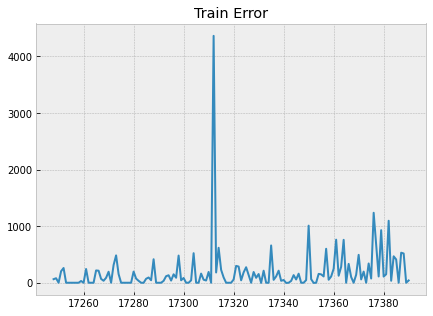

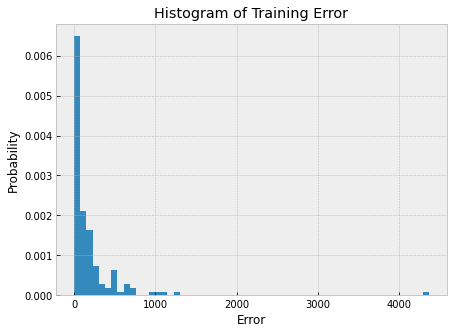

In [73]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(watches_gifts_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(watches_gifts_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [74]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [75]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 93826.82816166074
rms: 338.8946027752179
r2: -0.85665622300797
mape: 0.8128306490492511


### Plot Actulas & Forecasts

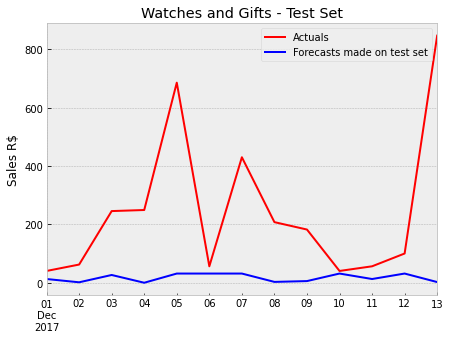

In [76]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Watches and Gifts - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

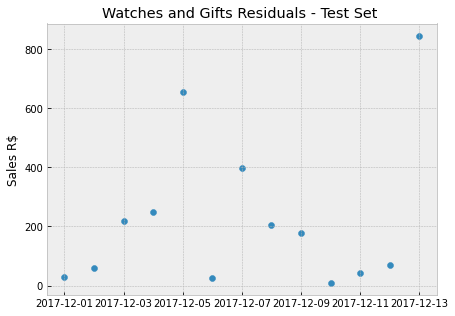

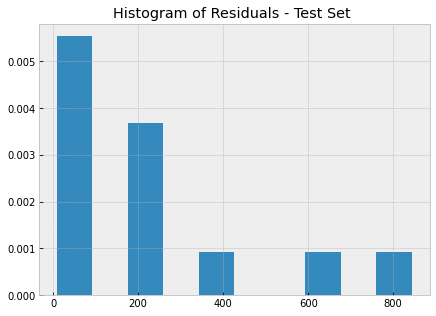

In [77]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Watches and Gifts Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

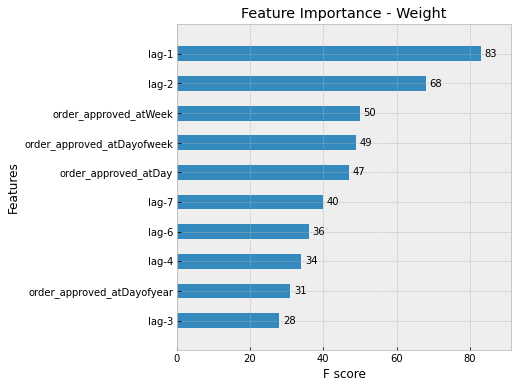

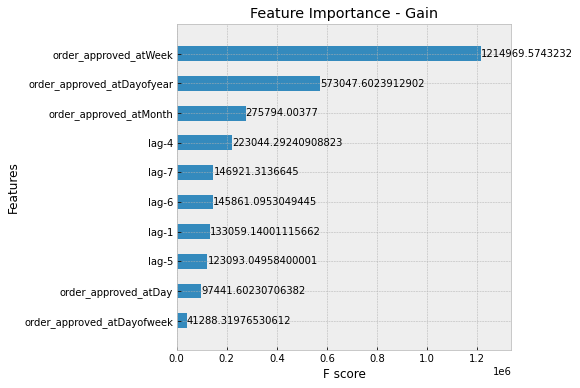

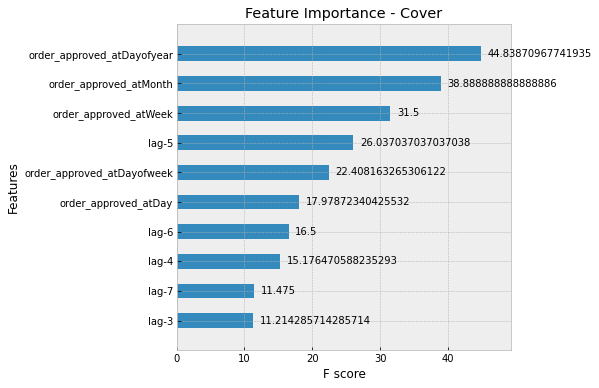

In [78]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

### Plot Regression Trees

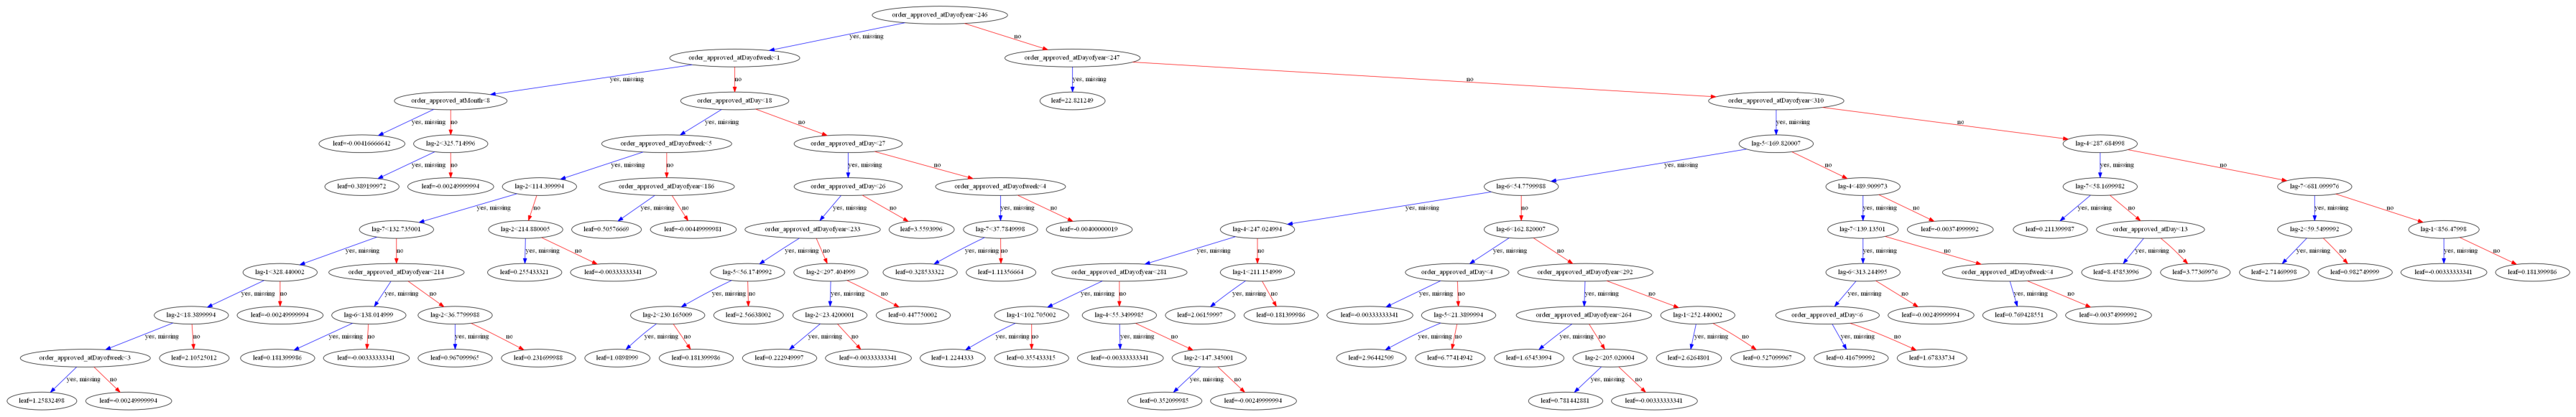

In [79]:
xgb.plot_tree(xg_boost_model,num_trees=0)
plt.rcParams['figure.figsize'] = [64, 64]
plt.show()

# Product Category 6: Telephony <a name = "telephony"/>

In [80]:
#Filter on product categories (series)
telephony_train = df_train.loc[df_train['product_category_name'] == 'telephony'].copy()
telephony_valid = df_valid.loc[df_valid['product_category_name'] == 'telephony'].copy()
telephony_test = df_test.loc[df_test['product_category_name'] == 'telephony'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

telephony_train.drop(columns, inplace=True, axis=1)
telephony_valid.drop(columns, inplace=True, axis=1)
telephony_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = telephony_train.loc[:, telephony_train.columns != 'payment_value']
y_train = telephony_train.loc[:, telephony_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = telephony_valid.loc[:, telephony_valid.columns != 'payment_value']
y_val = telephony_valid.loc[:, telephony_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = telephony_test.loc[:, telephony_test.columns != 'payment_value']
y_test = telephony_test.loc[:, telephony_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)


### Hyperparameter Optimization Using Hyperopt

In [81]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [82]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:33<00:00,  6.00trial/s, best loss: 3.019725210007292]
The best hyperparameters are: {'colsample_bytree': 0.9, 'eta': 0.011, 'max_depth': 7, 'min_child_weight': 2.0, 'n_estimators': 12, 'subsample': 0.9}


In [83]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

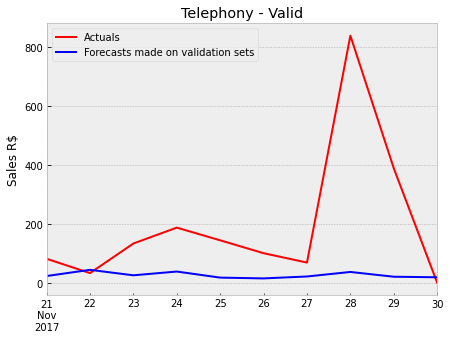

In [84]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals',figsize=(7,5))
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Telephony - Valid')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

In [85]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Product Category','Telephony')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: d171f6d283574d52ae937ed911a5729d


In [86]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 75566.31584079267
rms: 290.60728112691606
r2: -0.5027238631107589
mape: 3.2635144393392728


### Train & Run the XGBoost Model
Use optimized parameters determined by Hyperopt on the validation set

In [87]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = telephony_train.loc[:, telephony_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

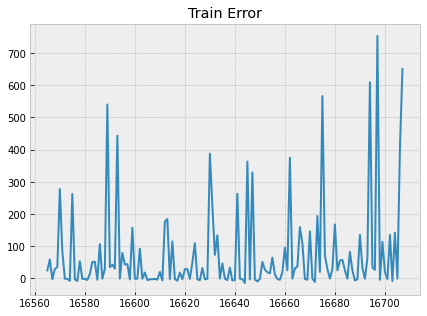

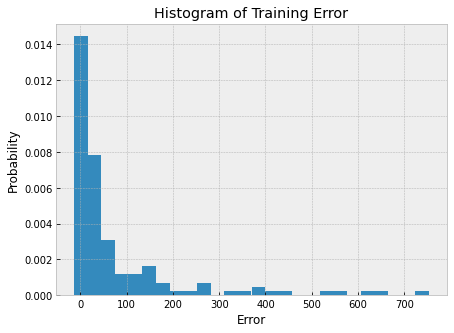

In [88]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(telephony_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(telephony_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [89]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [90]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 71606.81345924335
rms: 273.2869266629552
r2: -0.6269276854598418
mape: 4.438840474647897


### Plot Actuals & Forecasts

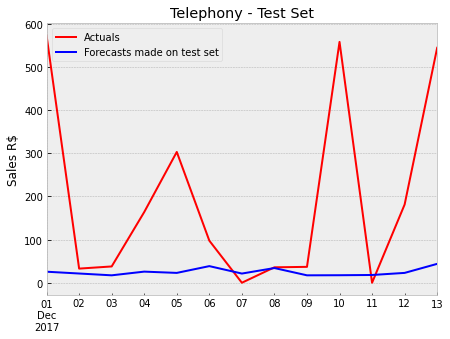

In [91]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Telephony - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

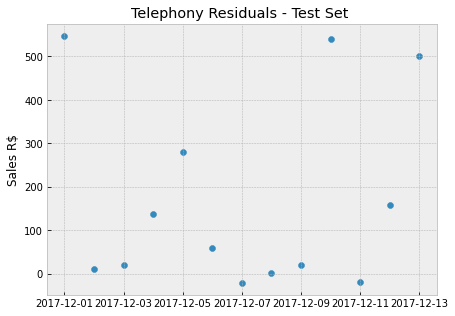

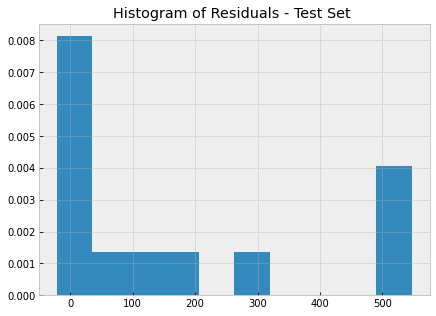

In [92]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Telephony Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover

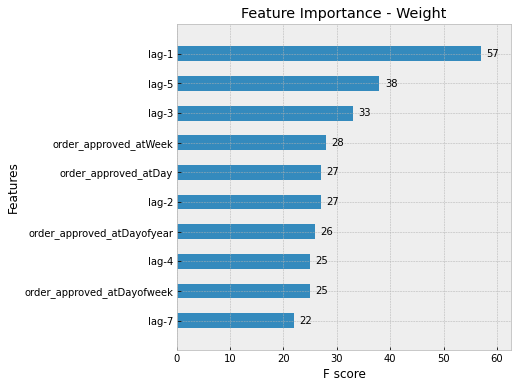

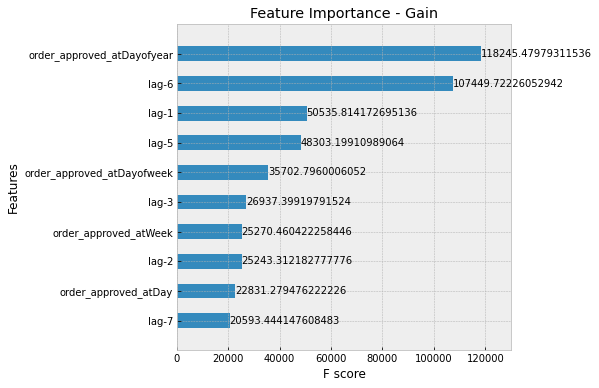

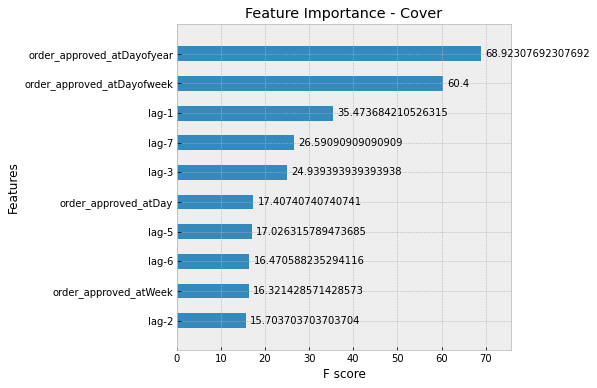

In [93]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

### Plot Regression Trees

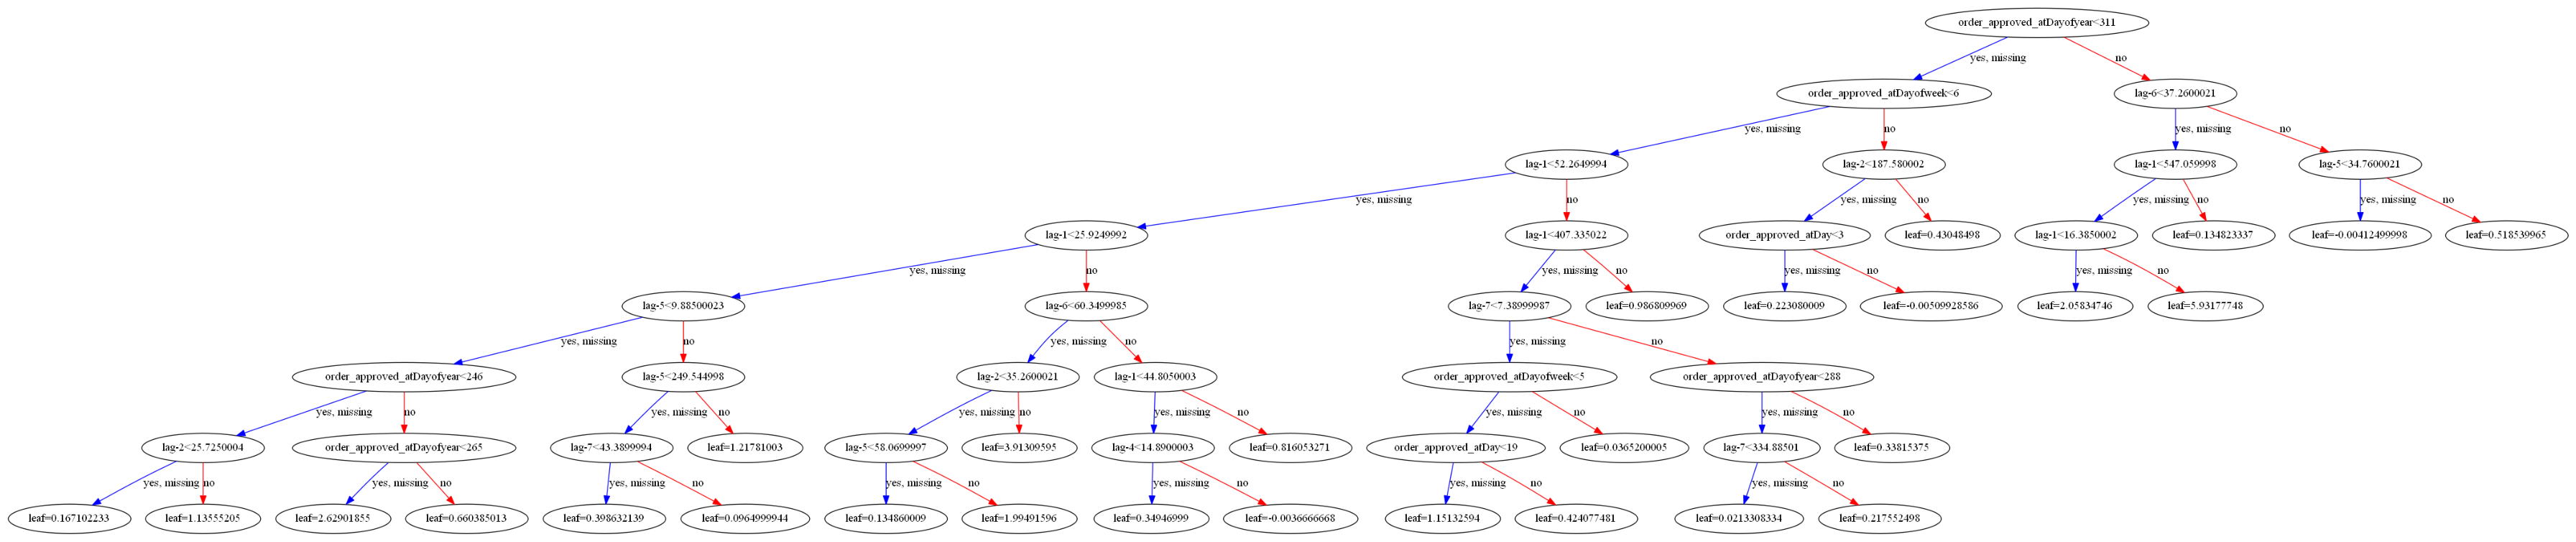

In [94]:
xgb.plot_tree(xg_boost_model,num_trees=0)
plt.rcParams['figure.figsize'] = [64, 64]
plt.show()

# Product Category 7: Housewares <a name = "housewares"/>

In [95]:
#Filter on product categories (series)
housewares_train = df_train.loc[df_train['product_category_name'] == 'housewares'].copy()
housewares_valid = df_valid.loc[df_valid['product_category_name'] == 'housewares'].copy()
housewares_test = df_test.loc[df_test['product_category_name'] == 'housewares'].copy()

#Drop columns that are no longer required
columns = ['product_category_name']

housewares_train.drop(columns, inplace=True, axis=1)
housewares_valid.drop(columns, inplace=True, axis=1)
housewares_test.drop(columns, inplace=True, axis=1)

#The XGBoost model expects input data in the form of a D-Matrix as opposed to a dataframe.
#Separate indepedent variables (X) from dependant/target variable (y) for train set
X_train = housewares_train.loc[:, housewares_train.columns != 'payment_value']
y_train = housewares_train.loc[:, housewares_train.columns == 'payment_value']

#Setup DMatrix for train set
data_dmatrix_train = xgb.DMatrix(data=X_train,label=y_train)


#Separate indepedent variables (X) from dependant/target variable (y) for validation set
X_val = housewares_valid.loc[:, housewares_valid.columns != 'payment_value']
y_val = housewares_valid.loc[:, housewares_valid.columns == 'payment_value']

#Setup DMatrix for validation set
data_dmatrix_val = xgb.DMatrix(data=X_val)

#Separate indepedent variables (X) from dependant/target variable (y) for test set
X_test = housewares_test.loc[:, housewares_test.columns != 'payment_value']
y_test = housewares_test.loc[:, housewares_test.columns == 'payment_value']

#Setup DMatrix for test set
data_dmatrix_test = xgb.DMatrix(data=X_test)


### Hyperparameter Optimization Using Hyperopt

In [96]:
#http://hyperopt.github.io/hyperopt/#documentation
#https://xgboost.readthedocs.io/en/latest/parameter.html
#https://github.com/JustinCharbonneau/Kaggle-Rossmann/blob/master/notebooks/1-model-xgboost.ipynb
#https://towardsdatascience.com/an-example-of-hyperparameter-optimization-on-xgboost-lightgbm-and-catboost-using-hyperopt-12bc41a271e

# Define search space to be used in space_eval
space = {
        # Range passed for learning rate
       'eta': hp.quniform('eta', 0.01, 0.3, 0.001),
        # Control overfitting
        # Maximum depth of a tree: default 6 -> range: [0:∞]
        'max_depth':  hp.choice('max_depth', np.arange(2, 10, dtype=int)),
        # Minimum sum of instance weight (hessian) needed in a child: default 1
        'min_child_weight': hp.quniform('min_child_weight', 1, 3, 1),
        # Add randomness to make training robust to noise (control overfitting)
        # Subsample ratio of the training instance: default 1
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        # Subsample ratio of columns when constructing each tree: default 1
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'n_estimators': hp.choice('n_estimators', np.arange(5, 100, dtype=int))
        }

#Search function that will return the parameter values for the optimized score
def optimize():
       
    # tpe.suggest is the algorithm used for updating the search space
    # trials are used to log the information
    # max_evals is used to specify how many combinations to look for

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=200)
   
    return best

#Function used to perform an evaluation on the validation set and return the score to the optimized function
def score(params):
    xg_boost_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                      colsample_bytree = params['colsample_bytree'],
                                      learning_rate = params['eta'],
                                      max_depth = params['max_depth'],
                                      min_child_weight = params['min_child_weight'],
                                      n_estimators = params['n_estimators'],
                                      random_state = 2020,
                                      subsample = params['subsample'],
                                      tree_method = 'hist') #tree methods used impact the training time
   
    xg_boost_model.fit(X_train,y_train)
   
    preds = xg_boost_model.predict(X_val)
   
    mape = metrics.mean_absolute_percentage_error(y_val, preds)
   
    return mape


In [97]:
#Run the search
# trials will contain logging information
trials = Trials()

best_hyperparams = optimize()

# Get max_depth mapping from the space - need to save space in a variable called space (out of the function)
params = space_eval(space, best_hyperparams)

print(f'The best hyperparameters are: {params}')

100%|██████████| 200/200 [00:34<00:00,  5.82trial/s, best loss: 0.4042507884689169]
The best hyperparameters are: {'colsample_bytree': 1.0, 'eta': 0.219, 'max_depth': 4, 'min_child_weight': 3.0, 'n_estimators': 17, 'subsample': 0.75}


In [98]:
num_rounds = params.pop('n_estimators')

### Report & Visualize Performance on the Validation Set

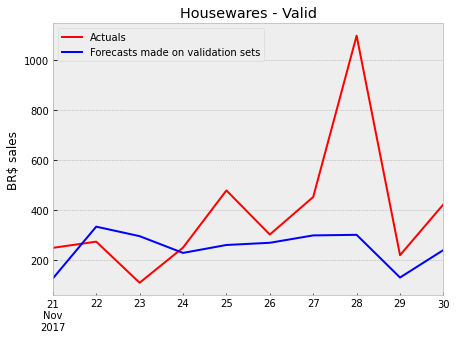

In [99]:
#Train on the validation set 
xg_boost_model_val = xgb.train(params, data_dmatrix_train, num_boost_round = num_rounds)

#Make predictions for the validation set using the optimal parameters

preds_val = xg_boost_model_val.predict(data_dmatrix_val)

y_val.set_index(valid_dates,inplace = True)

preds_val = pd.Series(preds_val,index = valid_dates)

ax = y_val.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals',figsize=(7,5))
preds_val.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on validation sets')
plt.title('Housewares - Valid')
plt.ylabel('BR$ sales')
plt.legend()
plt.show()

In [100]:
# Log parameters for the first and only time
# Key pre-processing steps should be also logged (window-size)
with mlflow.start_run() as run:
    mlflow.log_params(params)
    mlflow.log_param('window_size', 7)      
    mlflow.log_param('add_datepart', True)
    mlflow.log_param('Product Category','Housewares')

                                           
    current_run_id = run.info.run_id        # -> Set the run id to a variable that can be used throughout the notebook
    print(f'Current run id: {current_run_id}')

Current run id: 0bcbcf6600f44c25b8225d18ff0545dd


In [101]:
metrics.get_metrics(y_val, preds_val, run_id = current_run_id, log=True, param_prefix='validation')

wape: 100035.63413083568
rms: 283.54661888217345
r2: -0.17610435251582057
mape: 0.4524705970732185


### Train & Run the XGBoost Model¶
Use optimized parameters determined by Hyperopt on the validation set

In [102]:
xg_boost_model = xgb.train(params, data_dmatrix_train,num_boost_round = num_rounds)

X_train = housewares_train.loc[:, housewares_train.columns != 'payment_value']
data_dmatrix_train = xgb.DMatrix(X_train)
preds_fit = xg_boost_model.predict(data_dmatrix_train)

<function matplotlib.pyplot.show(*args, **kw)>

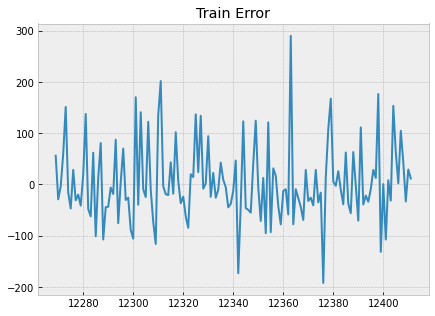

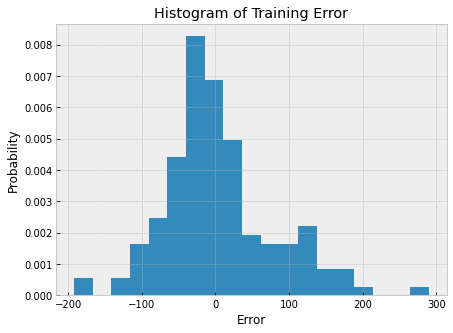

In [103]:
fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.title('Train Error')
pd.Series(housewares_train['payment_value'] - preds_fit).plot()

fig = plt.figure(figsize=(7,5))
fig = plt.figure
plt.hist(pd.Series(housewares_train['payment_value'] - preds_fit), density=True, bins = 'auto')
plt.ylabel('Probability')
plt.xlabel('Error')
plt.title('Histogram of Training Error')
plt.show

### Make Predictions

In [104]:
# make predictions on the testing set
preds = xg_boost_model.predict(data_dmatrix_test)

### Evaluate Performance

In [105]:
metrics.get_metrics(y_test, preds, run_id = current_run_id, log=True, param_prefix='testing')

wape: 269953.2498734346
rms: 548.8772999020109
r2: -0.3616471997676616
mape: 23.282037084097283


### Plot Actuals & Forecasts

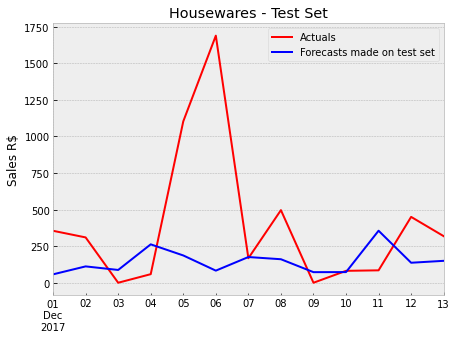

In [106]:
y_test.set_index(test_dates,inplace = True)

preds = pd.Series(preds,index = test_dates)

ax = y_test.plot(y = 'payment_value', kind = 'line' , color = 'red', label = 'Actuals', figsize=(7,5))

preds.plot(kind = 'line', ax = ax, color = 'blue', label = 'Forecasts made on test set')

plt.title('Housewares - Test Set')
plt.ylabel('Sales R$')
plt.legend()
plt.show()

### Plot Residuals

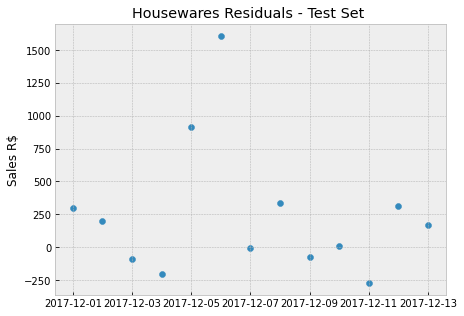

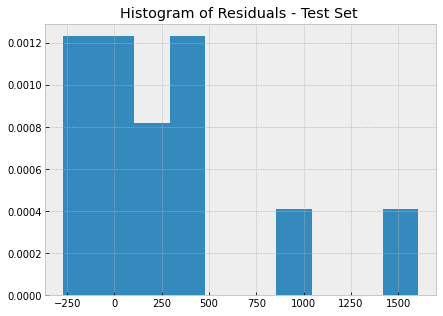

In [107]:
#Calcaulte Forecast Error
error = y_test.payment_value - preds 
y_true = pd.DataFrame({'residuals': error})

#Scatter Plot of Residuals
fig = plt.figure(figsize=(7,5))
plt.scatter( x=y_true.index, y=y_true.residuals)
plt.title('Housewares Residuals - Test Set ')
plt.ylabel('Sales R$')
plt.show()

#Histogram of Residuals
fig = plt.figure(figsize=(7,5))
plt.hist(x=error,density=True)
plt.title('Histogram of Residuals - Test Set ')
plt.show()

### Plot Top 10 Important Features by Weight, Gain and Cover¶

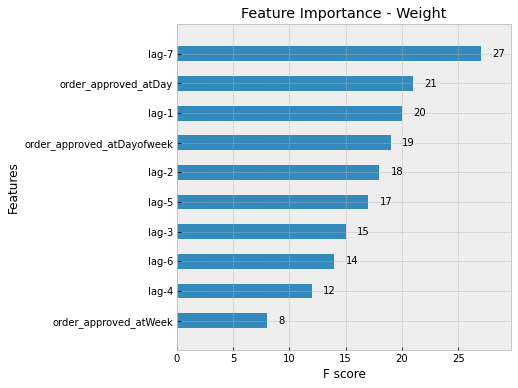

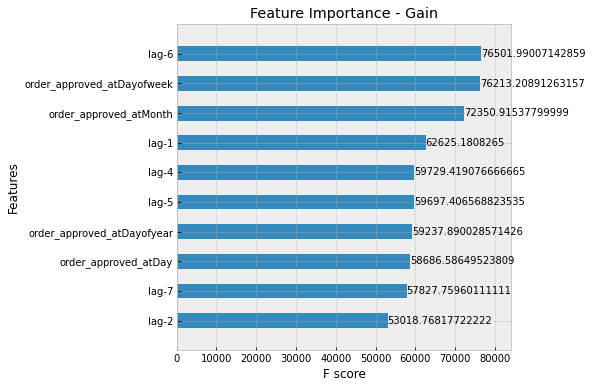

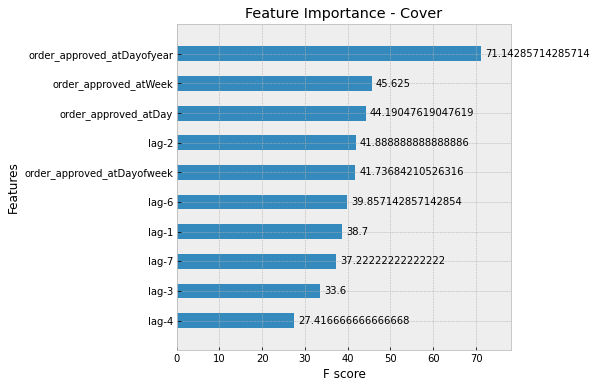

In [108]:
# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='weight' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Weight')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='gain' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Gain')
plt.show()

# plot feature importance, show top 10 features
fig, ax = plt.subplots(figsize=(6,6))
xgb.plot_importance(xg_boost_model, importance_type='cover' , max_num_features= 10, height=0.5, ax=ax, title = 'Feature Importance - Cover')
plt.show()

### Plot Regression Trees

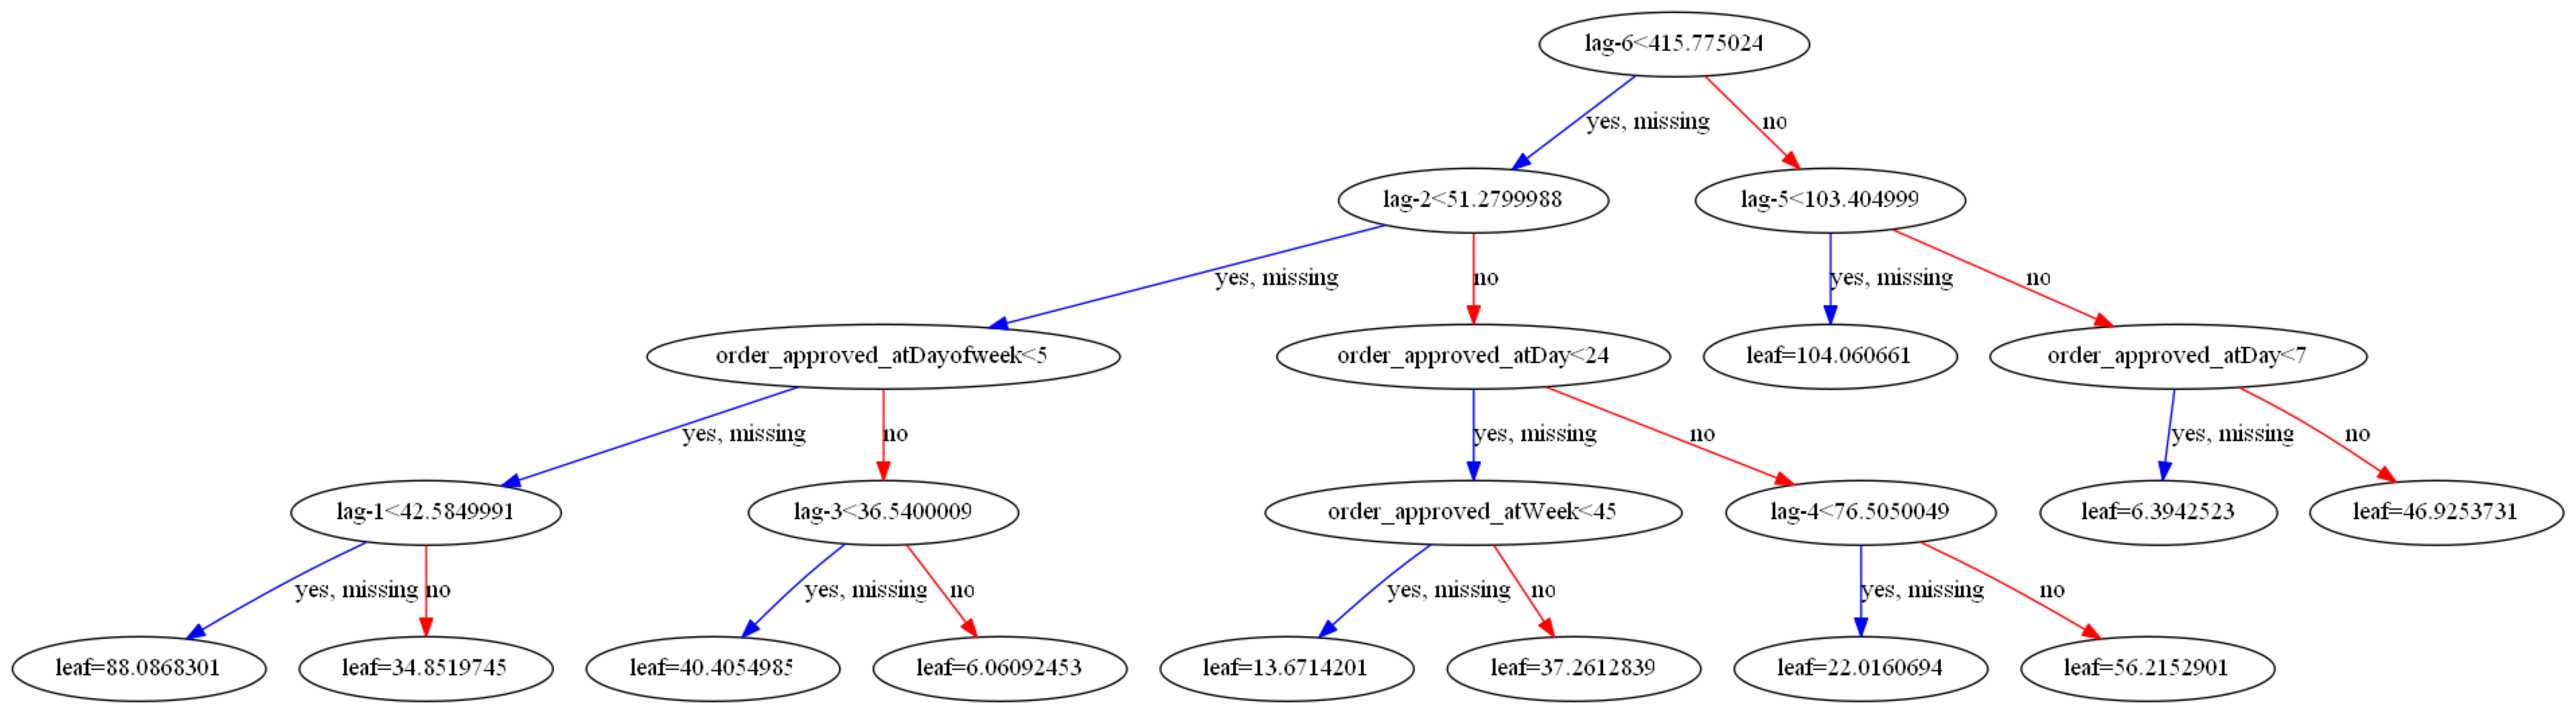

In [109]:
xgb.plot_tree(xg_boost_model,num_trees=0)
plt.rcParams['figure.figsize'] = [64, 64]
plt.show()